In [12]:
import os, sys
import iris
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import timeseries
import general_io as gio

In [13]:
infile_dict = {}
infile_dict['sfc-hflux-from-runoff'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-from-runoff/gn/v20191112/sfc-hflux-from-runoff-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['sfc-hflux-coupler'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-coupler/gn/v20191112/sfc-hflux-coupler-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['sfc-hflux-pme'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-pme/gn/v20191112/sfc-hflux-pme-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['frazil-3d'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/frazil-3d/gn/v20191112/frazil-3d-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['sfc-hflux-from-water-evap'] = ''
infile_dict['sfc-hflux-from-water-prec'] = ''
infile_dict['frazil-2d'] = ''
infile_dict['masso'] = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/masso/gn/v20191112/masso_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['thetaoga'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/thetaoga/gn/v20191112/thetaoga_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'

names = {}
names['sfc-hflux-from-runoff'] = 'heat flux (relative to 0C) from liquid river runoff'
names['sfc-hflux-coupler'] = 'surface heat flux coming through coupler'
names['sfc-hflux-pme'] = 'heat flux (relative to 0C) from pme transfer of water across ocean surface'
names['frazil-3d'] = 'ocn frazil heat flux over time step'
names['sfc-hflux-from-water-evap'] = 'heat flux from evap transfer of water across ocean surface'
names['sfc-hflux-from-water-prec'] = 'heat flux from precip transfer of water across ocean surface'
names['frazil-2d'] = 'ocn frazil heat flux over time step'

In [22]:
cp = 3992.10322329649; # J kg-1 degC-1

thetaoga_cube = iris.load_cube(infile_dict['thetaoga'], 'sea_water_potential_temperature')
thetaoga_cube = gio.temperature_unit_check(thetaoga_cube, 'K')
thetaoga_cube = timeseries.convert_to_annual(thetaoga_cube)

masso_cube = iris.load_cube(infile_dict['masso'], 'sea_water_mass')
ref_time_coord = masso_cube.coord('time')
masso_cube = timeseries.convert_to_annual(masso_cube)

ohc_data = masso_cube.data * thetaoga_cube.data * cp
ohc_anomaly_data = ohc_data - ohc_data[0]

thetaoga_anomaly_data = thetaoga_cube.data - thetaoga_cube.data[0]
thermal_data = cp * masso_cube.data[0] * thetaoga_anomaly_data

/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1928: UnknownCellMethodWarning: NetCDF variable 'thetaoga' contains unknown cell method 'cell'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


In [20]:
def read_flux(var, time_coord):
    """Read data"""
    
    infile = infile_dict[var]
    name = names[var]
    cube = iris.load_cube(infile, name)
    cube.coord('time').points = time_coord.points
    cube.coord('time').bounds = time_coord.bounds
    cube.coord('time').units = time_coord.units
    cube = timeseries.flux_to_total(cube)
    cube = timeseries.convert_to_annual(cube, aggregation='sum')
    cumsum_data = np.cumsum(cube.data)
    cumsum_anomaly = cumsum_data - cumsum_data[0]
    
    return cumsum_anomaly

In [23]:
data_dict = {}
var_list = ['sfc-hflux-from-runoff', 'sfc-hflux-coupler', 'sfc-hflux-pme', 'frazil-3d'] #'sfc-hflux-from-water-evap', 'sfc-hflux-from-water-prec', 'frazil-2d']
for var in var_list:
    data_dict[var] = read_flux(var, ref_time_coord)

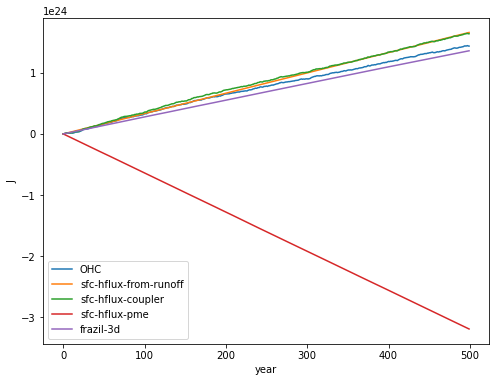

In [24]:
plt.figure(figsize=[8, 6])
plt.plot(ohc_anomaly_data, label='OHC')
for var in var_list:
    plt.plot(data_dict[var], label=var)
plt.ylabel('J')
plt.xlabel('year')
plt.legend()
plt.show()